# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(7) # Set the random seed so things are predictable
import random
random.seed(7)
np.random.seed(7)

# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Create training set and define training dataloader
## YOUR CODE HERE ##

# percentage of training set to use as validation
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

## taken from mnist_mlp_solution_with_validation.ipynb
num_workers = 0
valid_size = 0.2
batch_size = 64

# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testloader, batch_size=batch_size, 
    num_workers=num_workers)

cuda:0


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

A: The normalization transform was chosen to assist with gradient descent. Gradient descent on a multi-dimensional surface is easier when the gradients are of similar magnitude. Other transforms were not chosen at first so as to determine a baseline performance.

Of note, the much of the code in this project was developed by working through the Udacity-supplied tutorials in the deep-learning-v2-pytorch repository, especially the ones found in the intro-to-pytorch/ and convolutional-neural-netwokrs/ folders.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


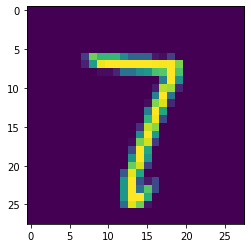

3


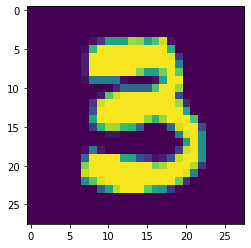

3


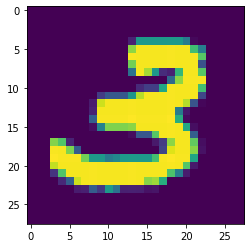

6


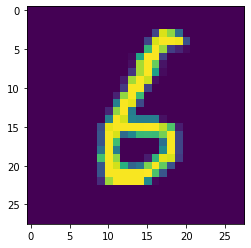

1


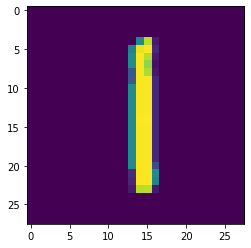

In [4]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
from torch import optim

model = Net()
print(model)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
## YOUR CODE HERE ##

def train(n_epochs):
    # number of epochs to train the model
    # n_epochs = 30  # suggest training between 20-50 epochs

    model.train() # prep model for training

    train_loss_vector = []
    valid_loss_vector = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for batch_idx, (data, target) in enumerate(train_loader):
            # print(data.size(), target.size())
            data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() #*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            data, target = data.cuda(), target.cuda()

            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += loss.item()     
            
        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/(len(train_loader))
        valid_loss = valid_loss/(len(valid_loader))

        train_loss_vector.append(train_loss)
        valid_loss_vector.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
    
    return train_loss_vector, valid_loss_vector

In [8]:
train_loss_vector, valid_loss_vector = train(n_epochs=20)

Epoch: 1 	Training Loss: 1.146688 	Validation Loss: 0.504909
Epoch: 2 	Training Loss: 0.414282 	Validation Loss: 0.378697
Epoch: 3 	Training Loss: 0.340895 	Validation Loss: 0.334211
Epoch: 4 	Training Loss: 0.307299 	Validation Loss: 0.304101
Epoch: 5 	Training Loss: 0.283079 	Validation Loss: 0.286899
Epoch: 6 	Training Loss: 0.263122 	Validation Loss: 0.265186
Epoch: 7 	Training Loss: 0.245543 	Validation Loss: 0.249745
Epoch: 8 	Training Loss: 0.229026 	Validation Loss: 0.245758
Epoch: 9 	Training Loss: 0.213831 	Validation Loss: 0.223884
Epoch: 10 	Training Loss: 0.200398 	Validation Loss: 0.212091
Epoch: 11 	Training Loss: 0.187850 	Validation Loss: 0.198829
Epoch: 12 	Training Loss: 0.176508 	Validation Loss: 0.191111
Epoch: 13 	Training Loss: 0.165420 	Validation Loss: 0.186272
Epoch: 14 	Training Loss: 0.157201 	Validation Loss: 0.174349
Epoch: 15 	Training Loss: 0.148407 	Validation Loss: 0.168889
Epoch: 16 	Training Loss: 0.140971 	Validation Loss: 0.161012
Epoch: 17 	Traini

Plot the training loss (and validation loss/accuracy, if recorded).

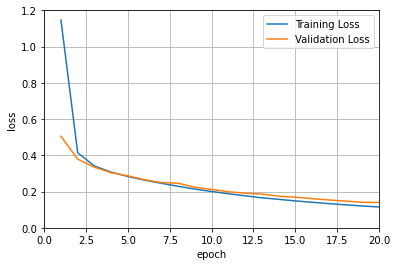

In [9]:
## YOUR CODE HERE ##
epoch_num = np.linspace(1, len(train_loss_vector), num=len(train_loss_vector))
plt.plot(epoch_num, train_loss_vector, label='Training Loss')
plt.plot(epoch_num, valid_loss_vector, label='Validation Loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(visible=True)
plt.xlim([0, len(train_loss_vector)]);
plt.ylim([0, 1.2]);
plt.legend();


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
def test():
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    batch_size = 16

    model.eval() # prep model for *evaluation*

    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(testloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    return

In [11]:
test()

Test Loss: 0.002045

Test Accuracy of     0: 97% (252/259)
Test Accuracy of     1: 99% (283/284)
Test Accuracy of     2: 98% (249/253)
Test Accuracy of     3: 95% (237/247)
Test Accuracy of     4: 97% (241/247)
Test Accuracy of     5: 94% (196/207)
Test Accuracy of     6: 97% (234/241)
Test Accuracy of     7: 94% (270/286)
Test Accuracy of     8: 93% (220/236)
Test Accuracy of     9: 93% (235/252)

Test Accuracy (Overall): 96% (2417/2512)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
## YOUR CODE HERE ##
optimizer = optim.SGD(model.parameters(), lr=0.005) # reduces the learning rate by half
train(n_epochs=10)
test() 

Epoch: 1 	Training Loss: 0.107067 	Validation Loss: 0.135778
Epoch: 2 	Training Loss: 0.104221 	Validation Loss: 0.136843
Epoch: 3 	Training Loss: 0.101943 	Validation Loss: 0.130226
Epoch: 4 	Training Loss: 0.099573 	Validation Loss: 0.128502
Epoch: 5 	Training Loss: 0.097206 	Validation Loss: 0.127394
Epoch: 6 	Training Loss: 0.094734 	Validation Loss: 0.127942
Epoch: 7 	Training Loss: 0.092513 	Validation Loss: 0.124391
Epoch: 8 	Training Loss: 0.090644 	Validation Loss: 0.123920
Epoch: 9 	Training Loss: 0.088377 	Validation Loss: 0.121484
Epoch: 10 	Training Loss: 0.086533 	Validation Loss: 0.119833
Test Loss: 0.001745

Test Accuracy of     0: 98% (257/262)
Test Accuracy of     1: 98% (276/280)
Test Accuracy of     2: 97% (228/235)
Test Accuracy of     3: 97% (246/252)
Test Accuracy of     4: 95% (247/259)
Test Accuracy of     5: 95% (182/190)
Test Accuracy of     6: 97% (237/244)
Test Accuracy of     7: 95% (263/275)
Test Accuracy of     8: 95% (259/270)
Test Accuracy of     9: 93

Note that the accuracy improved slightly from 2417/2512 to 2425/2512.

## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'checkpoint.pth')